In [1]:
import os
ROOT_PATH = 'D:\\projects\\spam-detection2\\'
DATA_PATH = os.path.join(ROOT_PATH, '../spam-detection-data/')

### Download and Preprocess Data

In [2]:
from utils.preprocessor import prepare_data
prepare_data()

Data already prepared. Loading from disk...

Data preparation complete!
Train: 4837, Test: 1210

Data preparation complete!
Train: 4837, Test: 1210


### SHAP & LIME Explainability for CNN Model

In [3]:
from utils.explainability import explain_cnn_with_shap, explain_cnn_with_lime
import shap
import matplotlib.pyplot as plt
import torch
import pandas as pd
from utils.functions import set_seed
from utils.preprocessor import load_glove_embeddings
from utils.functions import build_vocab

d:\projects\spam-detection2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load preprocessed data (assumes PKLs/CSVs are available in data/processed/)
train_df = pd.read_pickle(ROOT_PATH + 'data/processed/train.pkl')
test_df = pd.read_pickle(ROOT_PATH + 'data/processed/test.pkl')

set_seed(42)
word2idx = build_vocab(train_df['text'])

In [5]:
# Load GloVe embeddings
GLOVE_PATH = os.path.join(DATA_PATH, 'raw/glove.6B/glove.6B.300d.txt')
embedding_dim = 300
pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

100%|██████████| 10/10 [00:01<00:00,  9.56it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_38452\350461830.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_inputs.cpu().numpy(), feature_names=[f'w{i}' for i in range(max_len)])
d:\projects\spam-detection2\.venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

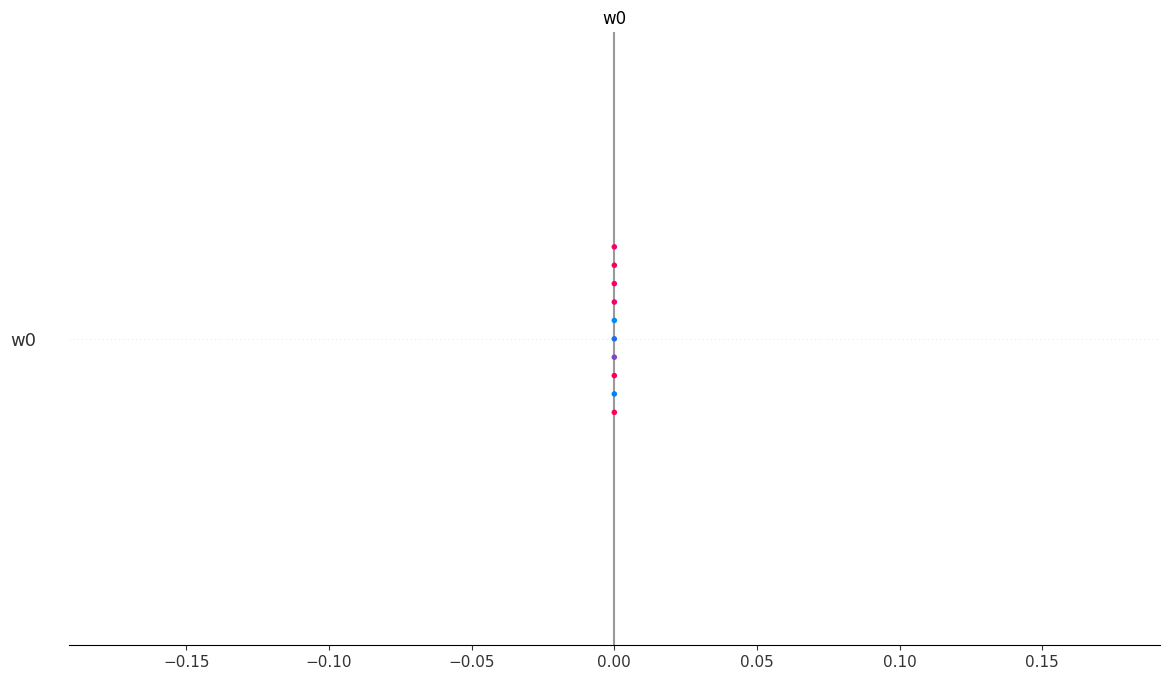

TypeError: Object of type ndarray is not JSON serializable

In [9]:
# Load your trained CNN model and data as in your training code
from models.cnn import SpamCNN

# Example: (adjust paths and variables as needed)
model = SpamCNN(vocab_size=len(word2idx), embedding_dim=300, pretrained_embeddings=pretrained_embeddings)
model.load('trained_models/spam_cnn.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

max_len = 200

def cnn_tokenizer(text, max_len=max_len):
    idxs = [word2idx.get(token, word2idx['<UNK>']) for token in text.split()]
    if len(idxs) < max_len:
        idxs += [word2idx['<PAD>']] * (max_len - len(idxs))
    else:
        idxs = idxs[:max_len]
    return idxs

sample_texts = test_df['text'].iloc[:10].tolist()

# SHAP explainability
shap_values, test_inputs = explain_cnn_with_shap(model, cnn_tokenizer, sample_texts, device, max_len=max_len, num_samples=10)
shap.summary_plot(shap_values, test_inputs.cpu().numpy(), feature_names=[f'w{i}' for i in range(max_len)])

# LIME explainability
lime_explainer = explain_cnn_with_lime(model, cnn_tokenizer, class_names=['ham', 'spam'], device=device, max_len=max_len)
lime_exp = lime_explainer(sample_texts[0])
# lime_exp.show_in_notebook(text=sample_texts[0])
# Save the LIME explanation as HTML for local viewing
with open("lime_explanation.html", "w", encoding="utf-8") as f:
    f.write(lime_exp.as_html())
print("LIME explanation saved to lime_explanation.html. Open this file in your browser to view the explanation.")